In [86]:
import numpy as np
from numpy import ma
import xarray as xr
from glob import glob
from datetime import datetime, timedelta
from scipy.signal import convolve
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from pyproj import Proj
import cv2 as cv
%matplotlib inline

In [2]:
import numpy as np
from datetime import datetime, timedelta
from pyproj import Proj
import xarray
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import sys
from matplotlib.animation import FuncAnimation
import glob

In [3]:
import xarray as xr
import iris
data_files = glob.glob('/home/bbrock/Desktop/June2019/june_26_177/OR*')
data_files.sort()

time = []
c13 = []

for i in data_files:
    ds = xarray.open_dataset(i)
    time.append(ds.t.data)
    c13.append(ds.CMI_C13.data)

In [4]:
t = np.array(time, dtype='datetime64[ns]')
c13 = np.array(c13)

In [5]:
ds

<xarray.Dataset>
Dimensions:                                 (band: 1, number_of_image_bounds: 2, number_of_time_bounds: 2, x: 2500, y: 1500)
Coordinates:
    t                                       datetime64[ns] 2019-06-26T21:57:38.859699072
  * y                                       (y) float32 0.128212 ... 0.044268005
  * x                                       (x) float32 -0.101332 ... 0.038612
    y_image                                 float32 ...
    x_image                                 float32 ...
    band_wavelength_C01                     (band) float32 ...
    band_wavelength_C02                     (band) float32 ...
    band_wavelength_C03                     (band) float32 ...
    band_wavelength_C04                     (band) float32 ...
    band_wavelength_C05                     (band) float32 ...
    band_wavelength_C06                     (band) float32 ...
    band_wavelength_C07                     (band) float32 ...
    band_wavelength_C08                    

In [6]:
da = xr.DataArray(c13, coords={'time': t, 'y': ds.y.data, 'x': ds.x.data},
                  dims=['time', 'y', 'x'])

In [90]:
C13 = da.to_iris()

In [58]:
a=C13[10:13]

In [92]:
C13

Unknown (unknown),time,y,x
Shape,60,1500,2500
Dimension coordinates,,,
time,x,-,-
y,-,x,-
x,-,-,x


[DimCoord(array([    0.        ,   300.0016311 ,   600.00561498,   900.00865805,
         1200.01209114,  1500.01261811,  1800.01823309,  2100.01892006,
         2400.0219721 ,  2700.02449408,  3000.02855309,  3300.02644416,
         3600.03400704,  3900.03303501,  4200.03919398,  4500.03849216,
         4800.04252211,  5100.04340506,  5400.04727706,  5700.04803802,
         6000.05314714,  6300.05447808,  6600.05804301,  6900.06030707,
         7200.06157402,  7500.06589312,  7800.06715405,  8100.07171405,
         8400.07556608,  8700.0743671 ,  9000.08139098,  9300.08031002,
         9600.08738598,  9900.0856151 , 10200.08933811, 10500.09008806,
        10800.09618406, 11100.09685709, 11400.09978304, 11700.1028951 ,
        12000.10630003, 12300.10518502, 12600.11179904, 12900.11006707,
        13200.11738304, 13500.1154601 , 13800.1204521 , 14100.12271411,
        14400.12599501, 14700.12703706, 15000.13106701, 15300.13262003,
        15600.13711795, 15900.13542106, 16200.13928806,

In [59]:
import tobac

In [60]:
# Set up directories to save output and plots:
savedir='Save1'
os.makedirs(savedir,exist_ok=True)
plot_dir="Plots1"
os.makedirs(plot_dir,exist_ok=True)

In [61]:
dxy,dt=tobac.get_spacings(a,grid_spacing=4000)

In [70]:
# Keyword arguments for the feature detection step
parameters_features={}
parameters_features['position_threshold']='weighted_diff'
parameters_features['sigma_threshold']=0.5
parameters_features['min_num']=1
parameters_features['target']='minimum'
parameters_features['threshold']=[250,225]

In [71]:
%%time
# Feature detection and save results to file:
print('starting feature detection')
Features=tobac.feature_detection_multithreshold(a,dxy,**parameters_features)
Features.to_hdf(os.path.join(savedir,'Features.h5'),'table')
print('feature detection performed and saved')

starting feature detection
feature detection performed and saved
CPU times: user 11min 20s, sys: 119 ms, total: 11min 20s
Wall time: 11min 20s


In [72]:
# Keyword arguments for the segmentation step:
parameters_segmentation={}
parameters_segmentation['target']='minimum'
parameters_segmentation['method']='watershed'
parameters_segmentation['threshold']=250

In [73]:
%%time
# Perform segmentation and save results to files:
Mask_OLR,Features_OLR=tobac.segmentation_2D(Features,C13,dxy,**parameters_segmentation)
print('segmentation C13 performed, start saving results to files')
iris.save([Mask_OLR],os.path.join(savedir,'Mask_Segmentation_c13.nc'),zlib=True,complevel=4)                
Features_OLR.to_hdf(os.path.join(savedir,'Features_c13.h5'),'table')
print('segmentation C13 performed and saved')

segmentation C13 performed, start saving results to files
segmentation C13 performed and saved
CPU times: user 55.1 s, sys: 108 ms, total: 55.2 s
Wall time: 55.1 s


In [74]:
# keyword arguments for linking step
parameters_linking={}
parameters_linking['v_max']=20
parameters_linking['stubs']=2
parameters_linking['order']=1
parameters_linking['extrapolate']=1
parameters_linking['memory']=0
parameters_linking['adaptive_stop']=0.2
parameters_linking['adaptive_step']=0.95
parameters_linking['subnetwork_size']=100
parameters_linking['method_linking']= 'predict'

In [75]:
# Perform linking and save results to file:
Track=tobac.linking_trackpy(Features,C13,dt=dt,dxy=dxy,**parameters_linking)
Track.to_hdf(os.path.join(savedir,'Track.h5'),'table')

Frame 2: 1951 trajectories present.


In [137]:
Track.loc[:, 'longitude'] = Track.loc[:, 'y']

In [ ]:
Track.loc[:, 'latitude'] = Track.loc[:, 'x']

In [141]:
Track.loc[:, 'x'] = lon

In [142]:
Track.loc[:, 'y'] = lat

In [143]:
Track

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,y,x,ncells,cell,time_cell,longitude,latitude
0,0,1,0.621253,751.140780,30,250,1,2019-06-26 17:52:38,2019-06-26 17:52:38,28.800001,-95.500001,32,1.0,00:00:00,0.128177,-0.059268
1,0,2,0.000000,768.000000,1,250,2,2019-06-26 17:52:38,2019-06-26 17:52:38,28.800001,-95.500001,3,NaN,NaT,0.128212,-0.058324
2,0,3,2.553809,1398.333129,122,250,3,2019-06-26 17:52:38,2019-06-26 17:52:38,28.800001,-95.500000,124,NaN,NaT,0.128069,-0.023025
3,0,5,0.737755,1865.830385,4,250,4,2019-06-26 17:52:38,2019-06-26 17:52:38,28.800001,-95.500000,0,NaN,NaT,0.128171,0.003155
4,0,6,1.239304,2129.925666,13,250,5,2019-06-26 17:52:38,2019-06-26 17:52:38,28.800001,-95.500000,14,5.0,00:00:00,0.128143,0.017944
5,0,7,3.538845,2171.722629,125,250,6,2019-06-26 17:52:38,2019-06-26 17:52:38,28.800001,-95.500000,130,6.0,00:00:00,0.128014,0.020284
6,0,8,11.950431,2245.768336,790,250,7,2019-06-26 17:52:38,2019-06-26 17:52:38,28.800001,-95.500000,792,NaN,NaT,0.127543,0.024431
7,0,9,0.000000,2266.000000,1,250,8,2019-06-26 17:52:38,2019-06-26 17:52:38,28.800001,-95.500000,1,8.0,00:00:00,0.128212,0.025564
8,0,10,2.043430,2278.891584,64,250,9,2019-06-26 17:52:38,2019-06-26 17:52:38,28.800001,-95.500000,51,NaN,NaT,0.128098,0.026286
9,0,11,0.000000,2292.000000,1,250,10,2019-06-26 17:52:38,2019-06-26 17:52:38,28.800001,-95.500000,2,NaN,NaT,0.128212,0.027020


In [124]:
y = Track['y'].to_list()

In [125]:
y

[0.12817721561131037,
 0.12821200489997864,
 0.12806899525044876,
 0.12817069166206949,
 0.12814260565830293,
 0.12801383467889685,
 0.1275427830369603,
 0.12821200489997864,
 0.12809757574112307,
 0.12821200489997864,
 0.12812692670234693,
 0.1280987573450953,
 0.12790983540045708,
 0.12813270823613007,
 0.12808007622663867,
 0.12810000777244568,
 0.12805389941030818,
 0.12798915212690554,
 0.1280440092086792,
 0.12793201208114624,
 0.12793201208114624,
 0.12786995088354083,
 0.1277226121376558,
 0.1247782580198286,
 0.12773274858118733,
 0.1274791118239953,
 0.12763314653586655,
 0.1276649283590846,
 0.12765200436115265,
 0.1275653002277291,
 0.12714829209425968,
 0.1274436289924975,
 0.1275400072336197,
 0.12733283869565828,
 0.12723343732183756,
 0.1270330902415639,
 0.12744634632177498,
 0.12742745090884977,
 0.12737201154232025,
 0.1273275703993091,
 0.1271439331431569,
 0.12736305720255336,
 0.12727345528286893,
 0.1271656780803035,
 0.1271276173681279,
 0.12715997713150187,
 0.

In [126]:
x = Track['x'].to_list()

In [127]:
import pyart


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/bbrock/.conda/envs/clouds_env/lib/python3.6/site-packages/pyart/graph/cm.py:104: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:
/home/bbrock/.conda/envs/clouds_env/lib/python3.6/site-packages/pyart/graph/cm_colorblind.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:


In [128]:
lon, lat = pyart.core.cartesian_to_geographic_aeqd(x, y, -95.5, 28.8)

5766

In [168]:
# Set extent of maps created in the following cells:
axis_extent=[-98,-93,27,31]
#axis_extent=[-10,10,0,5]

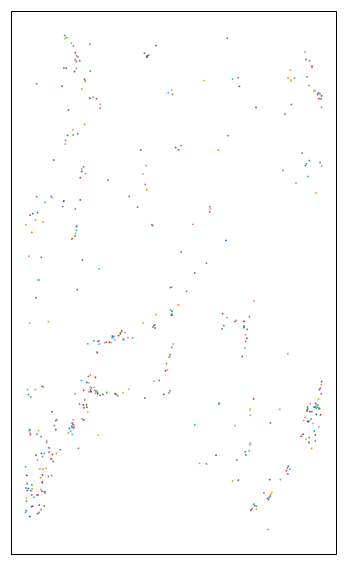

In [179]:
fig, ax_map = plt.subplots(figsize=(10,10), subplot_kw={'projection': ccrs.PlateCarree()})
for cell in Track['cell'].dropna().unique():
    track_i = Track[Track['cell']==cell]
    ax_map.plot(track_i['longitude'], track_i['latitude'],'-',
              transform=ccrs.AzimuthalEquidistant())

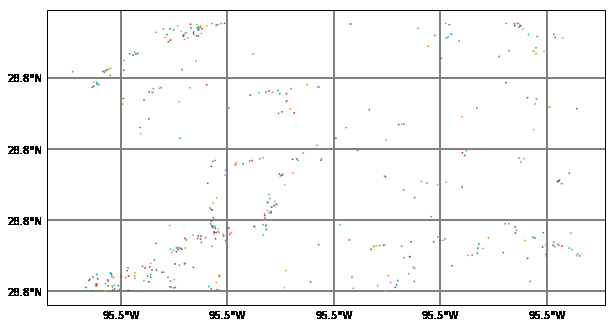

In [164]:
# Plot map with all individual tracks:
import cartopy.crs as ccrs
fig_map, ax_map = plt.subplots(figsize=(10,10), subplot_kw={'projection': ccrs.PlateCarree()})
tobac.map_tracks(Track, axes=ax_map)
#ax_map.set_extent(axis_extent, crs=ccrs.PlateCarree())
#ax_map.add_feature(cfeature.BORDERS, zorder=2000)
ax_map.coastlines('10m')
plt.show()

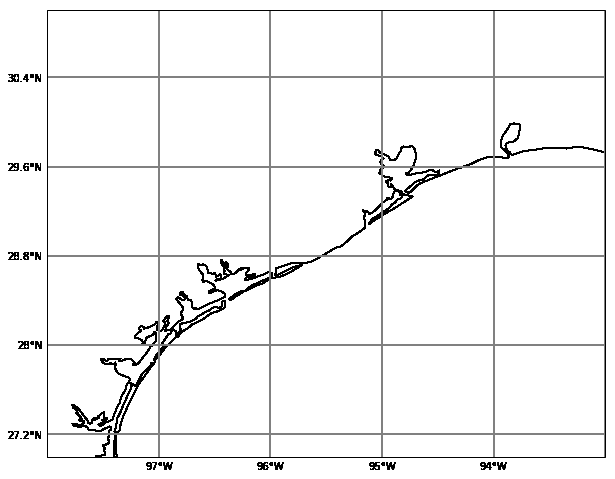

In [151]:
# Plot map with all individual tracks:
import cartopy.crs as ccrs
fig_map,ax_map=plt.subplots(figsize=(10,10), subplot_kw={'projection': ccrs.PlateCarree()})
ax_map=tobac.map_tracks(Track, axis_extent=axis_extent, axes=ax_map)

In [48]:
# Create animation of tracked clouds and outlines with OLR as a background field
animation_test_tobac=tobac.animation_mask_field(Track,Features,C13,Mask_OLR,
                                          axis_extent=axis_extent,#figsize=figsize,orientation_colorbar='horizontal',pad_colorbar=0.2,
                                          vmin=80,vmax=330,cmap='Blues_r',
                                          plot_outline=True,plot_marker=True,marker_track='x',plot_number=True,plot_features=True)

In [49]:
# Display animation:
from IPython.display import HTML, Image, display
HTML(animation_test_tobac.to_html5_video())

CoordinateNotFoundError: 'Expected to find exactly 1 longitude coordinate, but found none.'